# **1 Описание данных**




## Библиотеки

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install ETNA > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.
plotnine 0.12.4 requires statsmodels>=0.14.0, but you have statsmodels 0.13.5 which is incompatible.


In [ ]:
from etna.models import NaiveModel
from etna.models import MovingAverageModel
from etna.datasets.tsdataset import TSDataset
from etna.metrics import SMAPE
from etna.analysis import plot_forecast

In [ ]:
from etna.transforms import MeanTransform, LagTransform
from etna.analysis import plot_feature_relevance, ModelRelevanceTable
from sklearn.ensemble import RandomForestRegressor
from etna.models import CatBoostMultiSegmentModel
from etna.pipeline import Pipeline

In [ ]:
from etna.transforms import MeanTransform, LagTransform
from etna.analysis import plot_backtest

In [ ]:
from scipy import stats
from itertools import product
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from etna.models import SARIMAXModel

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from etna.models import HoltWintersModel, SimpleExpSmoothingModel, HoltModel

In [ ]:
model_names = []
smape_values = []
segment = []

data = {
    'Model Name': model_names,
    'SMAPE': smape_values,
    'Segment': segment
}

df = pd.DataFrame(data)
df


,Model Name,SMAPE,Segment


## Описание данных

В датасете находятся температуры разных городов собранные за один год.

# **2 Построение базовых моделей (baseline)**

Загружаем датасет

In [ ]:
original_df = pd.read_csv('daily-minimum-temperatures_3.csv')
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'])
original_df.head(400)

,timestamp,target,segment
0,1981-01-01,20.7,segment_a
1,1981-01-02,17.9,segment_a
2,1981-01-03,18.8,segment_a
3,1981-01-04,14.6,segment_a
4,1981-01-05,15.8,segment_a
...,...,...,...
395,1981-01-31,14.0,segment_b
396,1981-02-01,14.6,segment_b
397,1981-02-02,13.3,segment_b
398,1981-02-03,14.8,segment_b


In [ ]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1095 non-null   datetime64[ns]
 1   target     1095 non-null   float64       
 2   segment    1095 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.8+ KB


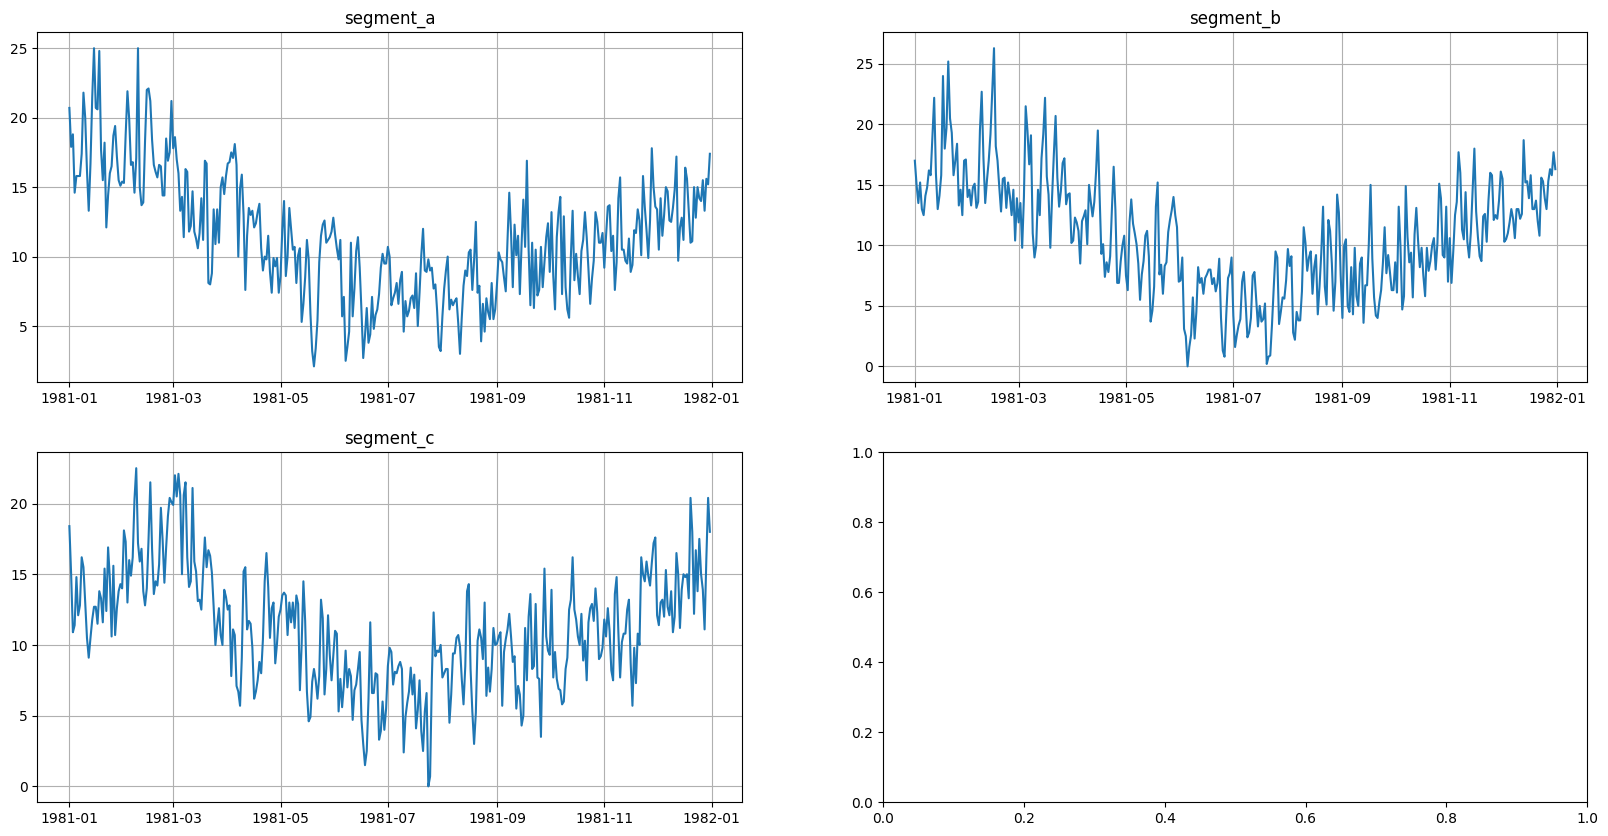

In [ ]:
df = TSDataset.to_dataset(original_df)
mult_ts = TSDataset(df, freq='D')
mult_ts.plot()

In [ ]:
mult_HORIZON = 7
train_mult_ts, test_mult_ts = mult_ts.train_test_split(
    train_start='1981-01-01',
    train_end='1981-12-24',
    test_start='1981-12-25',
    test_end='1981-12-31'
)

In [ ]:
model = NaiveModel()
model.fit(train_mult_ts)
future_mult_ts = train_mult_ts.make_future(mult_HORIZON, tail_steps=model.context_size)
future_mult_ts

segment,segment_a,segment_b,segment_c
feature,target,target,target
timestamp,,,
1981-12-24,15.0,15.3,13.8
1981-12-25,NaN,NaN,NaN
1981-12-26,NaN,NaN,NaN
1981-12-27,NaN,NaN,NaN
1981-12-28,NaN,NaN,NaN
1981-12-29,NaN,NaN,NaN
1981-12-30,NaN,NaN,NaN
1981-12-31,NaN,NaN,NaN


In [ ]:
forecast_mult_ts = model.forecast(future_mult_ts, prediction_size=mult_HORIZON)
forecast_mult_ts

segment,segment_a,segment_b,segment_c
feature,target,target,target
timestamp,,,
1981-12-25,15.0,15.3,13.8
1981-12-26,15.0,15.3,13.8
1981-12-27,15.0,15.3,13.8
1981-12-28,15.0,15.3,13.8
1981-12-29,15.0,15.3,13.8
1981-12-30,15.0,15.3,13.8
1981-12-31,15.0,15.3,13.8


In [ ]:
smape = SMAPE()
smape(y_true=test_mult_ts, y_pred=forecast_mult_ts)

{'segment_a': 6.818530476095007,
 'segment_b': 8.037510647739749,
 'segment_c': 19.2543536368864}

In [ ]:
df.loc[len(df)] = ['NaiveModel', 6.818530476095007, 'segment_a']
df.loc[len(df)] = ['NaiveModel', 8.037510647739749, 'segment_b']
df.loc[len(df)] = ['NaiveModel', 19.2543536368864, 'segment_c']

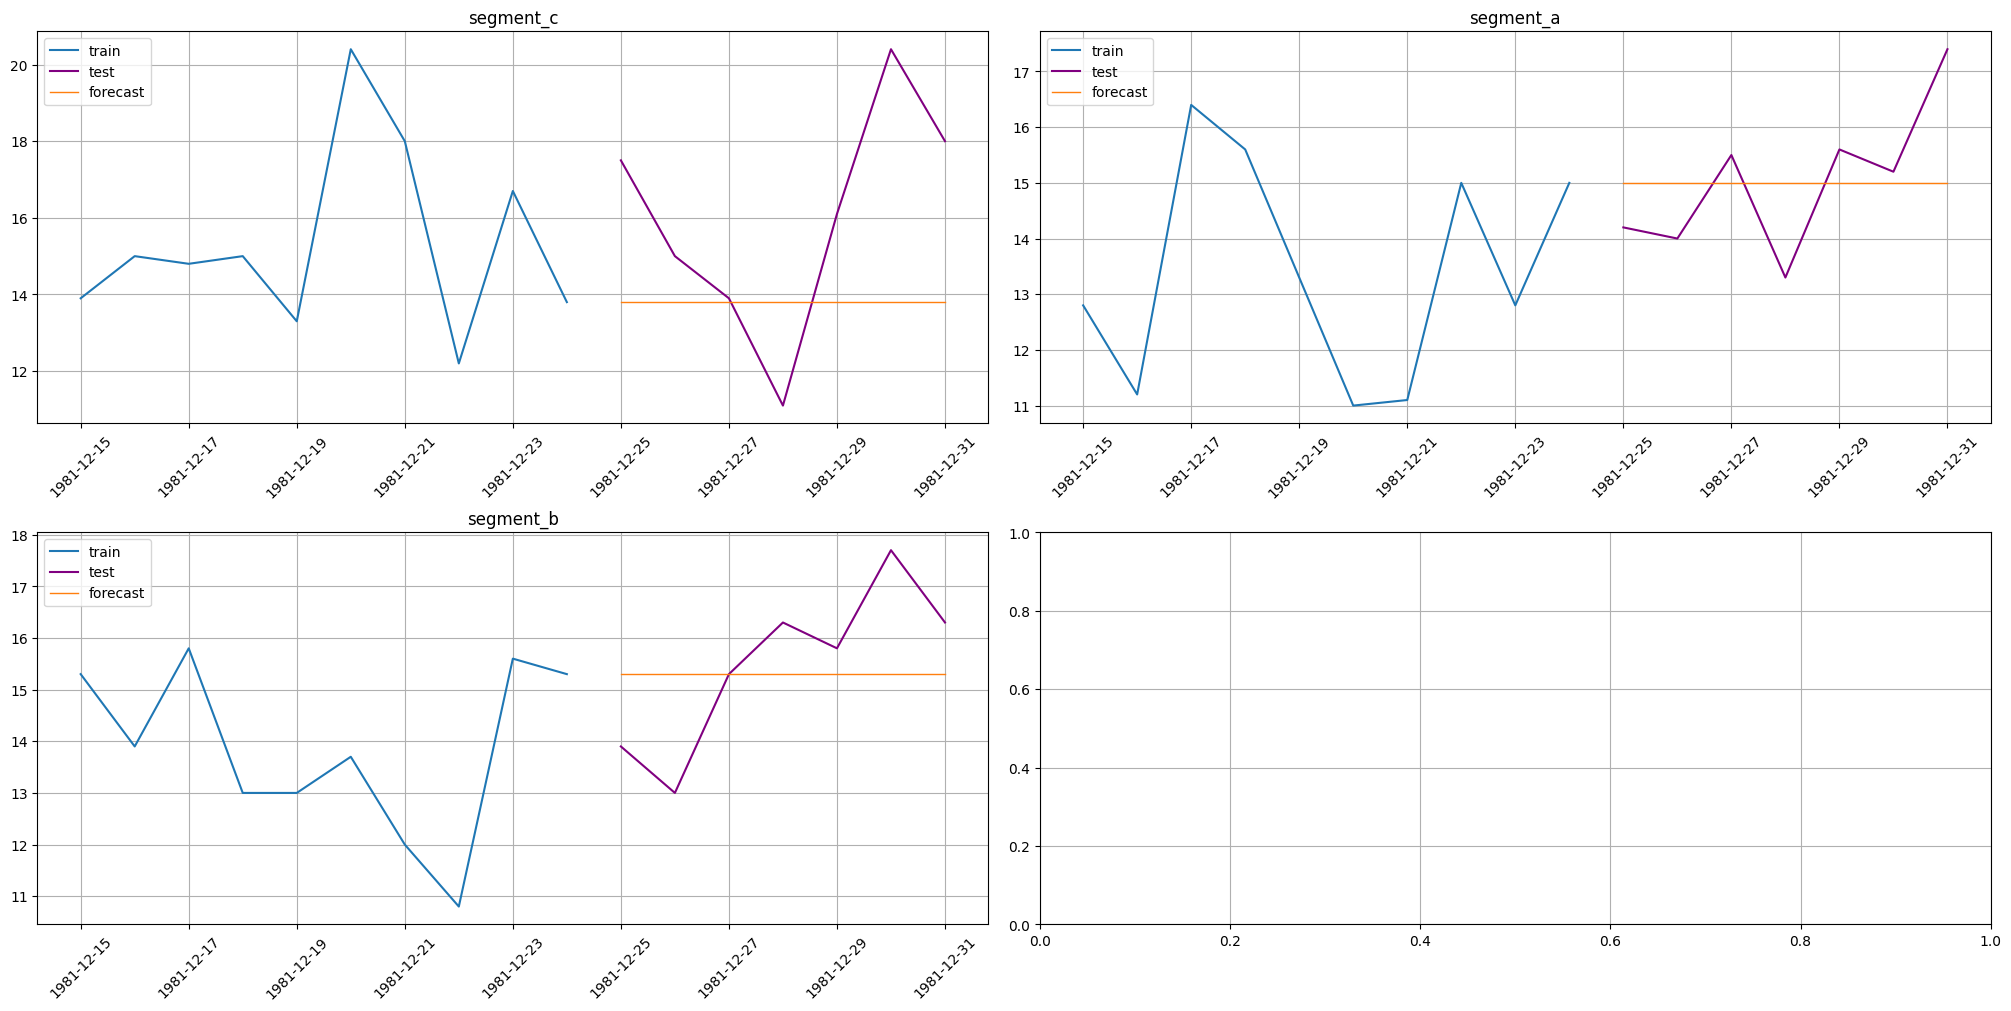

In [ ]:
plot_forecast(forecast_mult_ts, test_mult_ts, train_mult_ts, n_train_samples=10)

In [ ]:
model = MovingAverageModel(window=6)
model.fit(train_mult_ts)

future_mult_ts = train_mult_ts.make_future(mult_HORIZON, tail_steps=model.context_size)
future_mult_ts

segment,segment_a,segment_b,segment_c
feature,target,target,target
timestamp,,,
1981-12-19,13.3,13.0,13.3
1981-12-20,11.0,13.7,20.4
1981-12-21,11.1,12.0,18.0
1981-12-22,15.0,10.8,12.2
1981-12-23,12.8,15.6,16.7
1981-12-24,15.0,15.3,13.8
1981-12-25,NaN,NaN,NaN
1981-12-26,NaN,NaN,NaN


In [ ]:
forecast_mult_ts = model.forecast(future_mult_ts, prediction_size=mult_HORIZON)
forecast_mult_ts

segment,segment_a,segment_b,segment_c
feature,target,target,target
timestamp,,,
1981-12-25,13.033333,13.400000,15.733333
1981-12-26,12.988889,13.466667,16.138889
1981-12-27,13.320370,13.427778,15.428704
1981-12-28,13.690432,13.665741,15.000154
1981-12-29,13.472171,14.143364,15.466847
1981-12-30,13.584199,13.900592,15.261321
1981-12-31,13.348232,13.667357,15.504875


In [ ]:
smape = SMAPE()
smape(y_true=test_mult_ts, y_pred=forecast_mult_ts)

{'segment_a': 12.328455373133915,
 'segment_b': 12.92673244908062,
 'segment_c': 15.140347652374539}

In [ ]:
df.loc[len(df)] = ['MovingAverageModel', 12.328455373133915, 'segment_a']
df.loc[len(df)] = ['MovingAverageModel', 12.92673244908062, 'segment_b']
df.loc[len(df)] = ['MovingAverageModel', 15.140347652374539, 'segment_c']

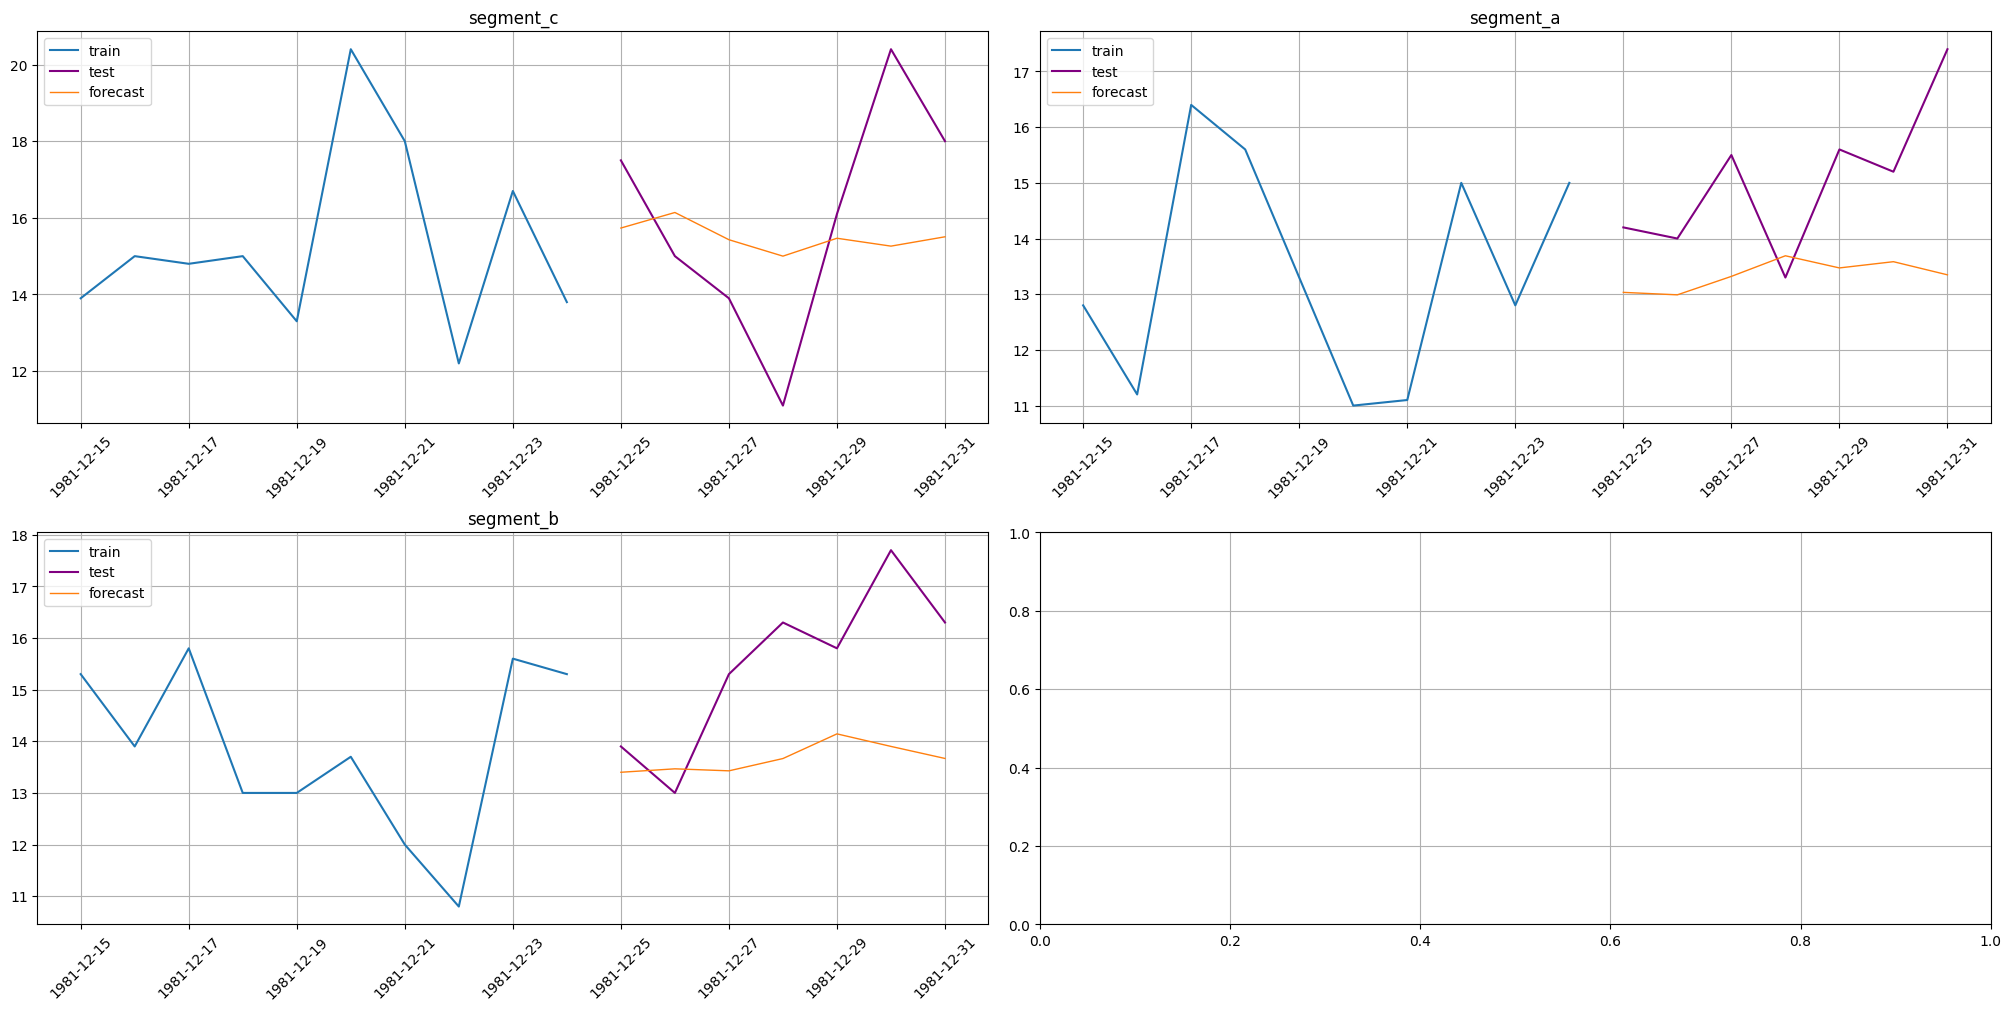

In [ ]:
plot_forecast(forecast_mult_ts, test_mult_ts, train_mult_ts, n_train_samples=10)

# **3 Построение модели CatBoost**

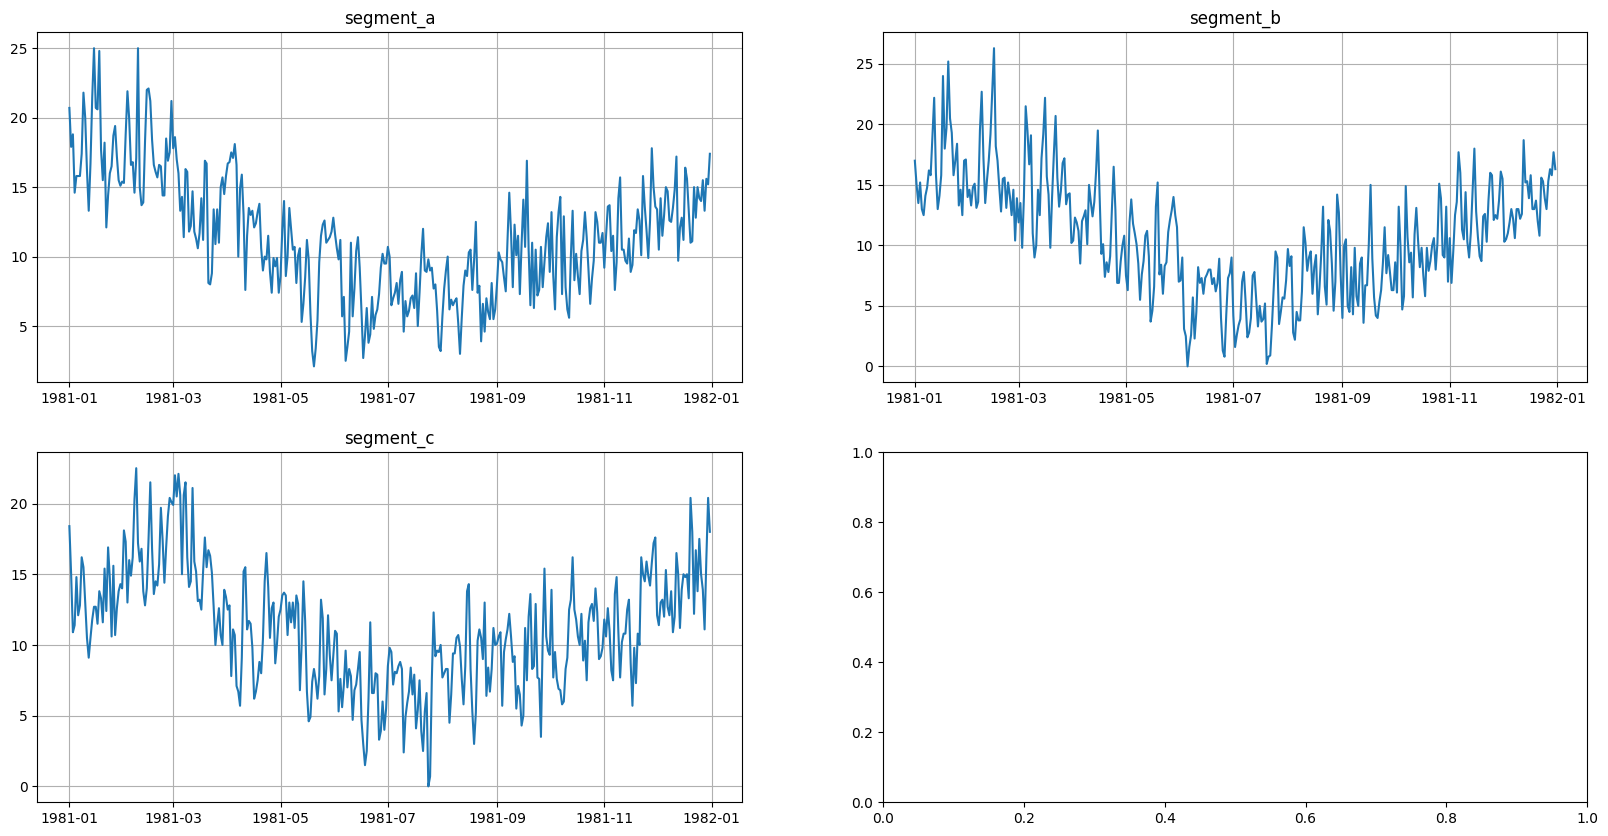

In [ ]:
original_df = pd.read_csv('daily-minimum-temperatures_3.csv')
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'])
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq='D')
ts.plot()

In [ ]:
HORIZON = 8
train_ts, test_ts = ts.train_test_split(
    train_start='1981-01-01',
    train_end = '1981-12-23',
    test_start = '1981-12-24',
    test_end = '1981-12-31'
)
train_ts, valid_ts = train_ts.train_test_split(
    train_start = '1981-01-01',
    train_end = '1981-12-15',
    test_start = '1981-12-16',
    test_end = '1981-12-23'
)


In [ ]:
train_ts

segment,segment_a,segment_b,segment_c
feature,target,target,target
timestamp,,,
1981-01-01,20.7,17.0,18.4
1981-01-02,17.9,15.0,15.0
1981-01-03,18.8,13.5,10.9
1981-01-04,14.6,15.2,11.4
1981-01-05,15.8,13.0,14.8
...,...,...,...
1981-12-11,14.8,12.2,12.0
1981-12-12,17.2,12.6,16.5


In [ ]:
valid_ts

segment,segment_a,segment_b,segment_c
feature,target,target,target
timestamp,,,
1981-12-16,11.2,13.9,15.0
1981-12-17,16.4,15.8,14.8
1981-12-18,15.6,13.0,15.0
1981-12-19,13.3,13.0,13.3
1981-12-20,11.0,13.7,20.4
1981-12-21,11.1,12.0,18.0
1981-12-22,15.0,10.8,12.2
1981-12-23,12.8,15.6,16.7


In [ ]:
test_ts

segment,segment_a,segment_b,segment_c
feature,target,target,target
timestamp,,,
1981-12-24,15.0,15.3,13.8
1981-12-25,14.2,13.9,17.5
1981-12-26,14.0,13.0,15.0
1981-12-27,15.5,15.3,13.9
1981-12-28,13.3,16.3,11.1
1981-12-29,15.6,15.8,16.1
1981-12-30,15.2,17.7,20.4
1981-12-31,17.4,16.3,18.0


In [ ]:
mean8 = MeanTransform(
    in_column='target',
    window=8,
    out_column='mean_08'
)
lags = LagTransform(
    in_column='target',
    lags=list(range(8, 24, 1)),
    out_column='lag'
)
train_ts.fit_transform([lags, mean8])
train_ts

segment    segment_a                                                          \
feature       lag_10 lag_11 lag_12 lag_13 lag_14 lag_15 lag_16 lag_17 lag_18   
timestamp                                                                      
1981-01-01       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1981-01-02       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1981-01-03       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1981-01-04       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1981-01-05       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...              ...    ...    ...    ...    ...    ...    ...    ...    ...   
1981-12-11      13.4   13.6   15.0   17.8   12.6    9.9   11.9   13.6   15.8   
1981-12-12      10.5   13.4   13.6   15.0   17.8   12.6    9.9   11.9   13.6   
1981-12-13      14.2   10.5   13.4   13.6   15.0   17.8   12.6    9.9   11.9   
1981-12-14      11.5   14.2   10.5   13.4   13.6   15.0   17.8   12.6    9.9   
1981-12-15      13.0   11.5   14.2   10.5   13.4   13.6   15.0   17.8   12.6   

segment            ... segment_c                                           \
feature    lag_19  ...    lag_18 lag_19 lag_20 lag_21 lag_22 lag_23 lag_8   
timestamp          ...                                                      
1981-01-01    NaN  ...       NaN    NaN    NaN    NaN    NaN    NaN   NaN   
1981-01-02    NaN  ...       NaN    NaN    NaN    NaN    NaN    NaN   NaN   
1981-01-03    NaN  ...       NaN    NaN    NaN    NaN    NaN    NaN   NaN   
1981-01-04    NaN  ...       NaN    NaN    NaN    NaN    NaN    NaN   NaN   
1981-01-05    NaN  ...       NaN    NaN    NaN    NaN    NaN    NaN   NaN   
...           ...  ...       ...    ...    ...    ...    ...    ...   ...   
1981-12-11   10.1  ...      15.0   16.2   10.0   10.8    7.3    9.8  13.0   
1981-12-12   15.8  ...      14.5   15.0   16.2   10.0   10.8    7.3  13.2   
1981-12-13   13.6  ...      15.9   14.5   15.0   16.2   10.0   10.8  12.0   
1981-12-14   11.9  ...      14.9   15.9   14.5   15.0   16.2   10.0  15.3   
1981-12-15    9.9  ...      14.2   14.9   15.9   14.5   15.0   16.2  12.7   

segment                             
feature    lag_9    mean_08 target  
timestamp                           
1981-01-01   NaN  18.400000   18.4  
1981-01-02   NaN  16.700000   15.0  
1981-01-03   NaN  14.766667   10.9  
1981-01-04   NaN  13.925000   11.4  
1981-01-05   NaN  14.100000   14.8  
...          ...        ...    ...  
1981-12-11  11.4  12.750000   12.0  
1981-12-12  13.0  13.162500   16.5  
1981-12-13  13.2  13.537500   15.0  
1981-12-14  12.0  13.025000   11.2  
1981-12-15  15.3  13.175000   13.9  

[349 rows x 54 columns]

In [ ]:
train_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
segment_a,1981-01-01,1981-12-15,349,0,3,17,16,0,D
segment_b,1981-01-01,1981-12-15,349,0,3,17,16,0,D
segment_c,1981-01-01,1981-12-15,349,0,3,17,16,0,D


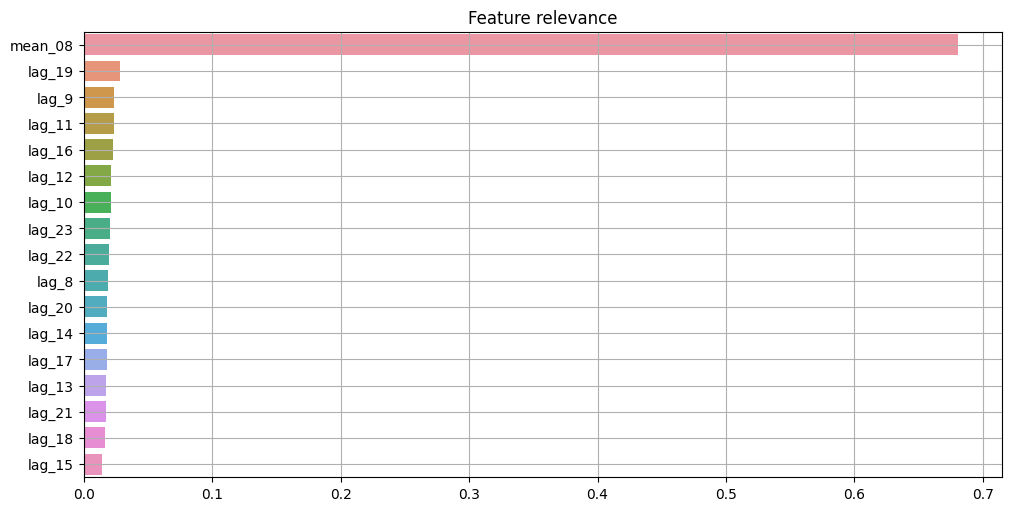

In [ ]:
plot_feature_relevance(
    ts=train_ts,
    relevance_table=ModelRelevanceTable(),
    normalized=True,
    top_k=20,
    relevance_params=dict(model=RandomForestRegressor(n_estimators=100))
)

In [ ]:
model = CatBoostMultiSegmentModel(loss_function='MAE',
                                  n_estimators=600,
                                  learning_rate=0.05,
                                  depth=9,
                                  random_seed=42)
model.fit(train_ts)

CatBoostMultiSegmentModel(iterations = None, depth = 9, learning_rate = 0.05, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, loss_function = 'MAE', n_estimators = 600, random_seed = 42, )

In [ ]:
future_ts = train_ts.make_future(
    HORIZON,
    transforms=[lags, mean8]
)
future_ts

segment    segment_a                                                          \
feature       lag_10 lag_11 lag_12 lag_13 lag_14 lag_15 lag_16 lag_17 lag_18   
timestamp                                                                      
1981-12-16      15.0   13.0   11.5   14.2   10.5   13.4   13.6   15.0   17.8   
1981-12-17      14.7   15.0   13.0   11.5   14.2   10.5   13.4   13.6   15.0   
1981-12-18      12.6   14.7   15.0   13.0   11.5   14.2   10.5   13.4   13.6   
1981-12-19      12.5   12.6   14.7   15.0   13.0   11.5   14.2   10.5   13.4   
1981-12-20      13.5   12.5   12.6   14.7   15.0   13.0   11.5   14.2   10.5   
1981-12-21      14.8   13.5   12.5   12.6   14.7   15.0   13.0   11.5   14.2   
1981-12-22      17.2   14.8   13.5   12.5   12.6   14.7   15.0   13.0   11.5   
1981-12-23       9.7   17.2   14.8   13.5   12.5   12.6   14.7   15.0   13.0   

segment            ... segment_c                                           \
feature    lag_19  ...    lag_18 lag_19 lag_20 lag_21 lag_22 lag_23 lag_8   
timestamp          ...                                                      
1981-12-16   12.6  ...      15.8   14.2   14.9   15.9   14.5   15.0  12.1   
1981-12-17   17.8  ...      17.2   15.8   14.2   14.9   15.9   14.5  13.8   
1981-12-18   15.0  ...      17.6   17.2   15.8   14.2   14.9   15.9  10.9   
1981-12-19   13.6  ...      12.1   17.6   17.2   15.8   14.2   14.9  12.0   
1981-12-20   13.4  ...      11.4   12.1   17.6   17.2   15.8   14.2  16.5   
1981-12-21   10.5  ...      13.0   11.4   12.1   17.6   17.2   15.8  15.0   
1981-12-22   14.2  ...      13.2   13.0   11.4   12.1   17.6   17.2  11.2   
1981-12-23   11.5  ...      12.0   13.2   13.0   11.4   12.1   17.6  13.9   

segment                             
feature    lag_9    mean_08 target  
timestamp                           
1981-12-16  12.7  13.328571    NaN  
1981-12-17  12.1  13.250000    NaN  
1981-12-18  13.8  13.720000    NaN  
1981-12-19  10.9  14.150000    NaN  
1981-12-20  12.0  13.366667    NaN  
1981-12-21  16.5  12.550000    NaN  
1981-12-22  15.0  13.900000    NaN  
1981-12-23  11.2   0.000000    NaN  

[8 rows x 54 columns]

In [ ]:
forecast_ts = model.forecast(future_ts)
forecast_ts

segment    segment_a                                                          \
feature       lag_10 lag_11 lag_12 lag_13 lag_14 lag_15 lag_16 lag_17 lag_18   
timestamp                                                                      
1981-12-16      15.0   13.0   11.5   14.2   10.5   13.4   13.6   15.0   17.8   
1981-12-17      14.7   15.0   13.0   11.5   14.2   10.5   13.4   13.6   15.0   
1981-12-18      12.6   14.7   15.0   13.0   11.5   14.2   10.5   13.4   13.6   
1981-12-19      12.5   12.6   14.7   15.0   13.0   11.5   14.2   10.5   13.4   
1981-12-20      13.5   12.5   12.6   14.7   15.0   13.0   11.5   14.2   10.5   
1981-12-21      14.8   13.5   12.5   12.6   14.7   15.0   13.0   11.5   14.2   
1981-12-22      17.2   14.8   13.5   12.5   12.6   14.7   15.0   13.0   11.5   
1981-12-23       9.7   17.2   14.8   13.5   12.5   12.6   14.7   15.0   13.0   

segment            ... segment_c                                           \
feature    lag_19  ...    lag_18 lag_19 lag_20 lag_21 lag_22 lag_23 lag_8   
timestamp          ...                                                      
1981-12-16   12.6  ...      15.8   14.2   14.9   15.9   14.5   15.0  12.1   
1981-12-17   17.8  ...      17.2   15.8   14.2   14.9   15.9   14.5  13.8   
1981-12-18   15.0  ...      17.6   17.2   15.8   14.2   14.9   15.9  10.9   
1981-12-19   13.6  ...      12.1   17.6   17.2   15.8   14.2   14.9  12.0   
1981-12-20   13.4  ...      11.4   12.1   17.6   17.2   15.8   14.2  16.5   
1981-12-21   10.5  ...      13.0   11.4   12.1   17.6   17.2   15.8  15.0   
1981-12-22   14.2  ...      13.2   13.0   11.4   12.1   17.6   17.2  11.2   
1981-12-23   11.5  ...      12.0   13.2   13.0   11.4   12.1   17.6  13.9   

segment                                 
feature    lag_9    mean_08     target  
timestamp                               
1981-12-16  12.7  13.328571  13.307678  
1981-12-17  12.1  13.250000  13.316573  
1981-12-18  13.8  13.720000  13.562172  
1981-12-19  10.9  14.150000  16.140644  
1981-12-20  12.0  13.366667  13.236603  
1981-12-21  16.5  12.550000  12.521161  
1981-12-22  15.0  13.900000  14.266530  
1981-12-23  11.2   0.000000   7.674641  

[8 rows x 54 columns]

In [ ]:
smape = SMAPE()
smape(y_true=valid_ts, y_pred=forecast_ts)

{'segment_a': 18.811089834667914,
 'segment_b': 21.90568260626312,
 'segment_c': 27.505044392192584}

In [ ]:
df.loc[len(df)] = ['CatBoostMultiSegmentModel', 18.811089834667914, 'segment_a']
df.loc[len(df)] = ['CatBoostMultiSegmentModel', 21.90568260626312, 'segment_b']
df.loc[len(df)] = ['CatBoostMultiSegmentModel', 27.505044392192584, 'segment_c']

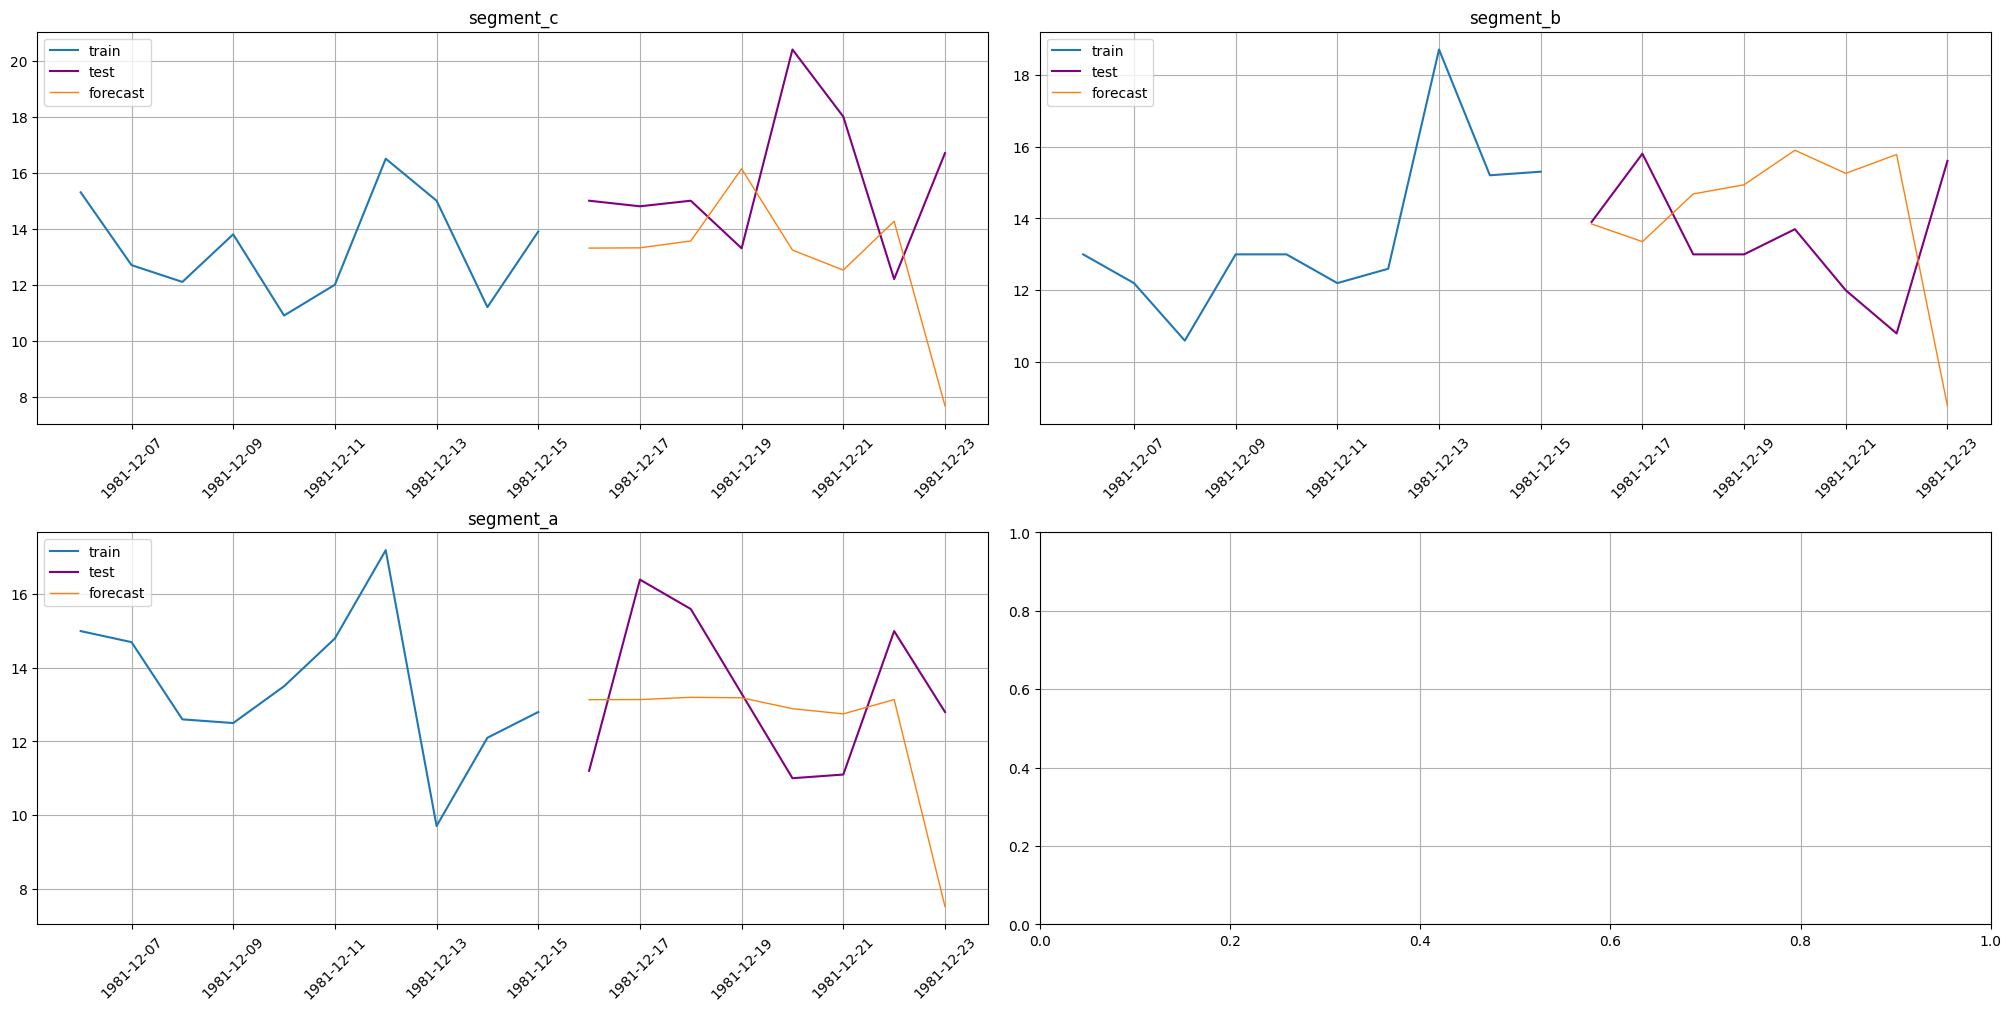

In [ ]:
plot_forecast(forecast_ts, valid_ts, train_ts, n_train_samples=10)

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start='1981-01-01',
    train_end = '1981-12-23',
    test_start = '1981-12-24',
    test_end = '1981-12-31'
)
train_ts, valid_ts = train_ts.train_test_split(
    train_start = '1981-01-01',
    train_end = '1981-12-15',
    test_start = '1981-12-16',
    test_end = '1981-12-23'
)
lags2 = LagTransform(
    in_column='target',
    lags=list(range(8, 13, 1)),
    out_column='lag'
)

In [ ]:
pipeline = Pipeline(
    model=model,
    transforms=[lags2, mean8],
    horizon=HORIZON
)
pipeline.fit(train_ts)

Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = 9, learning_rate = 0.05, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, loss_function = 'MAE', n_estimators = 600, random_seed = 42, ), transforms = [LagTransform(in_column = 'target', lags = [8, 9, 10, 11, 12], out_column = 'lag', ), MeanTransform(in_column = 'target', window = 8, seasonality = 1, alpha = 1, min_periods = 1, fillna = 0, out_column = 'mean_08', )], horizon = 8, )

In [ ]:
forecast_ts = pipeline.forecast()
print(smape(y_true=valid_ts, y_pred=forecast_ts))

{'segment_a': 20.621872201259634, 'segment_b': 26.777286330295713, 'segment_c': 31.529249894861906}


In [ ]:
df.loc[len(df)] = ['CatBoostMultiSegmentModel с обновленным признаковым пространством', 20.621872201259634, 'segment_a']
df.loc[len(df)] = ['CatBoostMultiSegmentModel с обновленным признаковым пространством', 26.777286330295713, 'segment_b']
df.loc[len(df)] = ['CatBoostMultiSegmentModel с обновленным признаковым пространством', 31.529249894861906, 'segment_c']

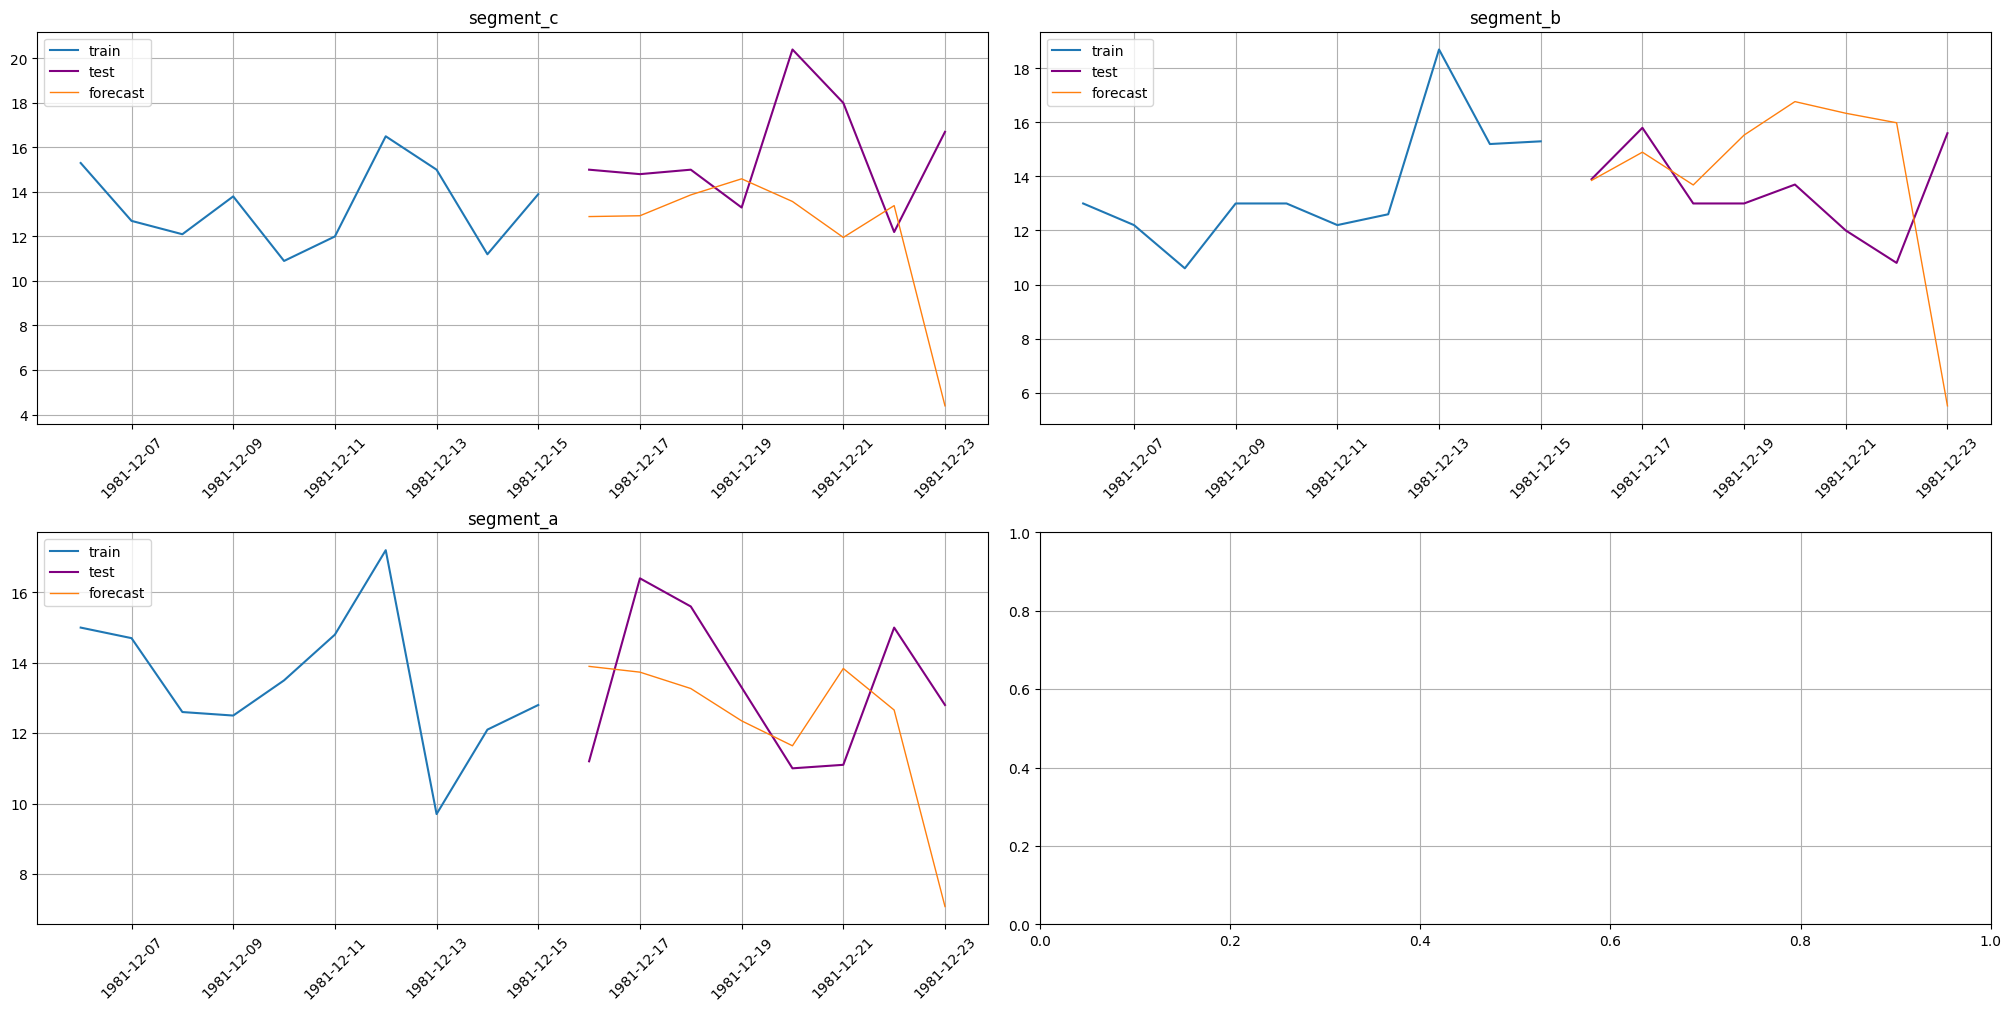

In [ ]:
plot_forecast(forecast_ts, valid_ts, train_ts, n_train_samples=10)

# **4 Подбор признакового пространства для модели CatBoost**

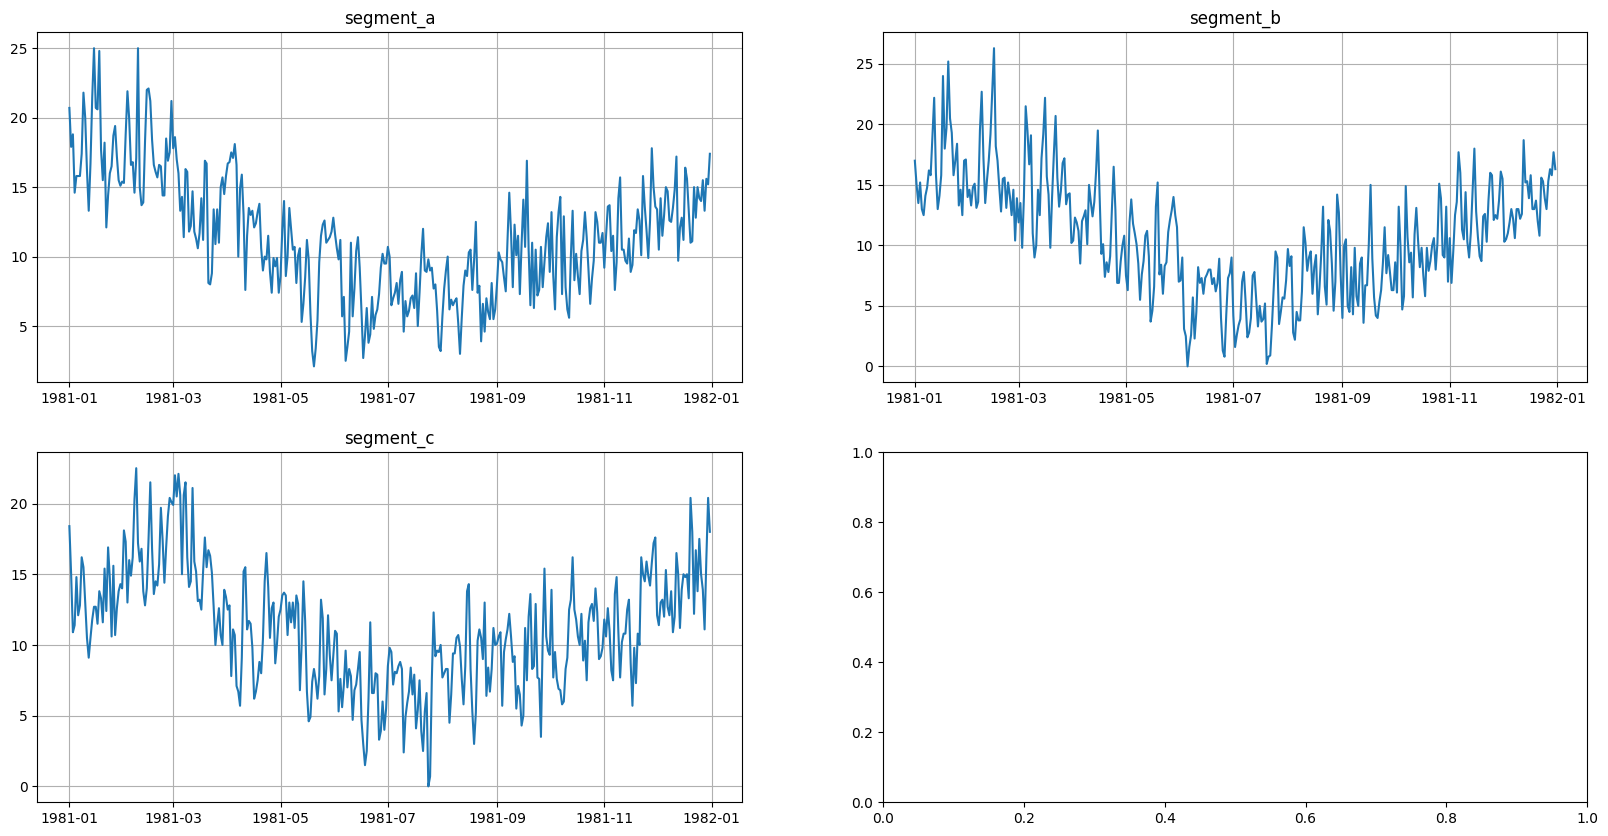

In [ ]:
original_df = pd.read_csv('daily-minimum-temperatures_3.csv')
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'])
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq='D')
ts.plot()

In [ ]:
HORIZON = 8
mean8 = MeanTransform(
    in_column='target',
    window=8,
    out_column='mean_08'
)
lags = LagTransform(
    in_column='target',
    lags=list(range(8, 24, 1)),
    out_column='lag'
)
lags2 = LagTransform(
    in_column='target',
    lags=list(range(8, 13, 1)),
    out_column='lag'
)

In [ ]:
model = CatBoostMultiSegmentModel(loss_function='MAE',
                                  n_estimators=600,
                                  learning_rate=0.05,
                                  depth=9,
                                  random_seed=42)

## Подбор пространства используя lags1

In [ ]:
transforms = [lags, mean8]
pipeline = Pipeline(model=model,
                    transforms=transforms,
                    horizon=HORIZON)

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start='1981-01-01',
    train_end = '1981-12-23',
    test_start = '1981-12-24',
    test_end = '1981-12-31'
)

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    mode='expand',
    ts=train_ts,
    metrics=[smape]
)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   19.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   33.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   47.7s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

In [ ]:
fold_info_df

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,1981-01-01,1981-11-13,1981-11-14,1981-11-21,0
1,1981-01-01,1981-11-21,1981-11-22,1981-11-29,1
2,1981-01-01,1981-11-29,1981-11-30,1981-12-07,2
3,1981-01-01,1981-12-07,1981-12-08,1981-12-15,3
4,1981-01-01,1981-12-15,1981-12-16,1981-12-23,4


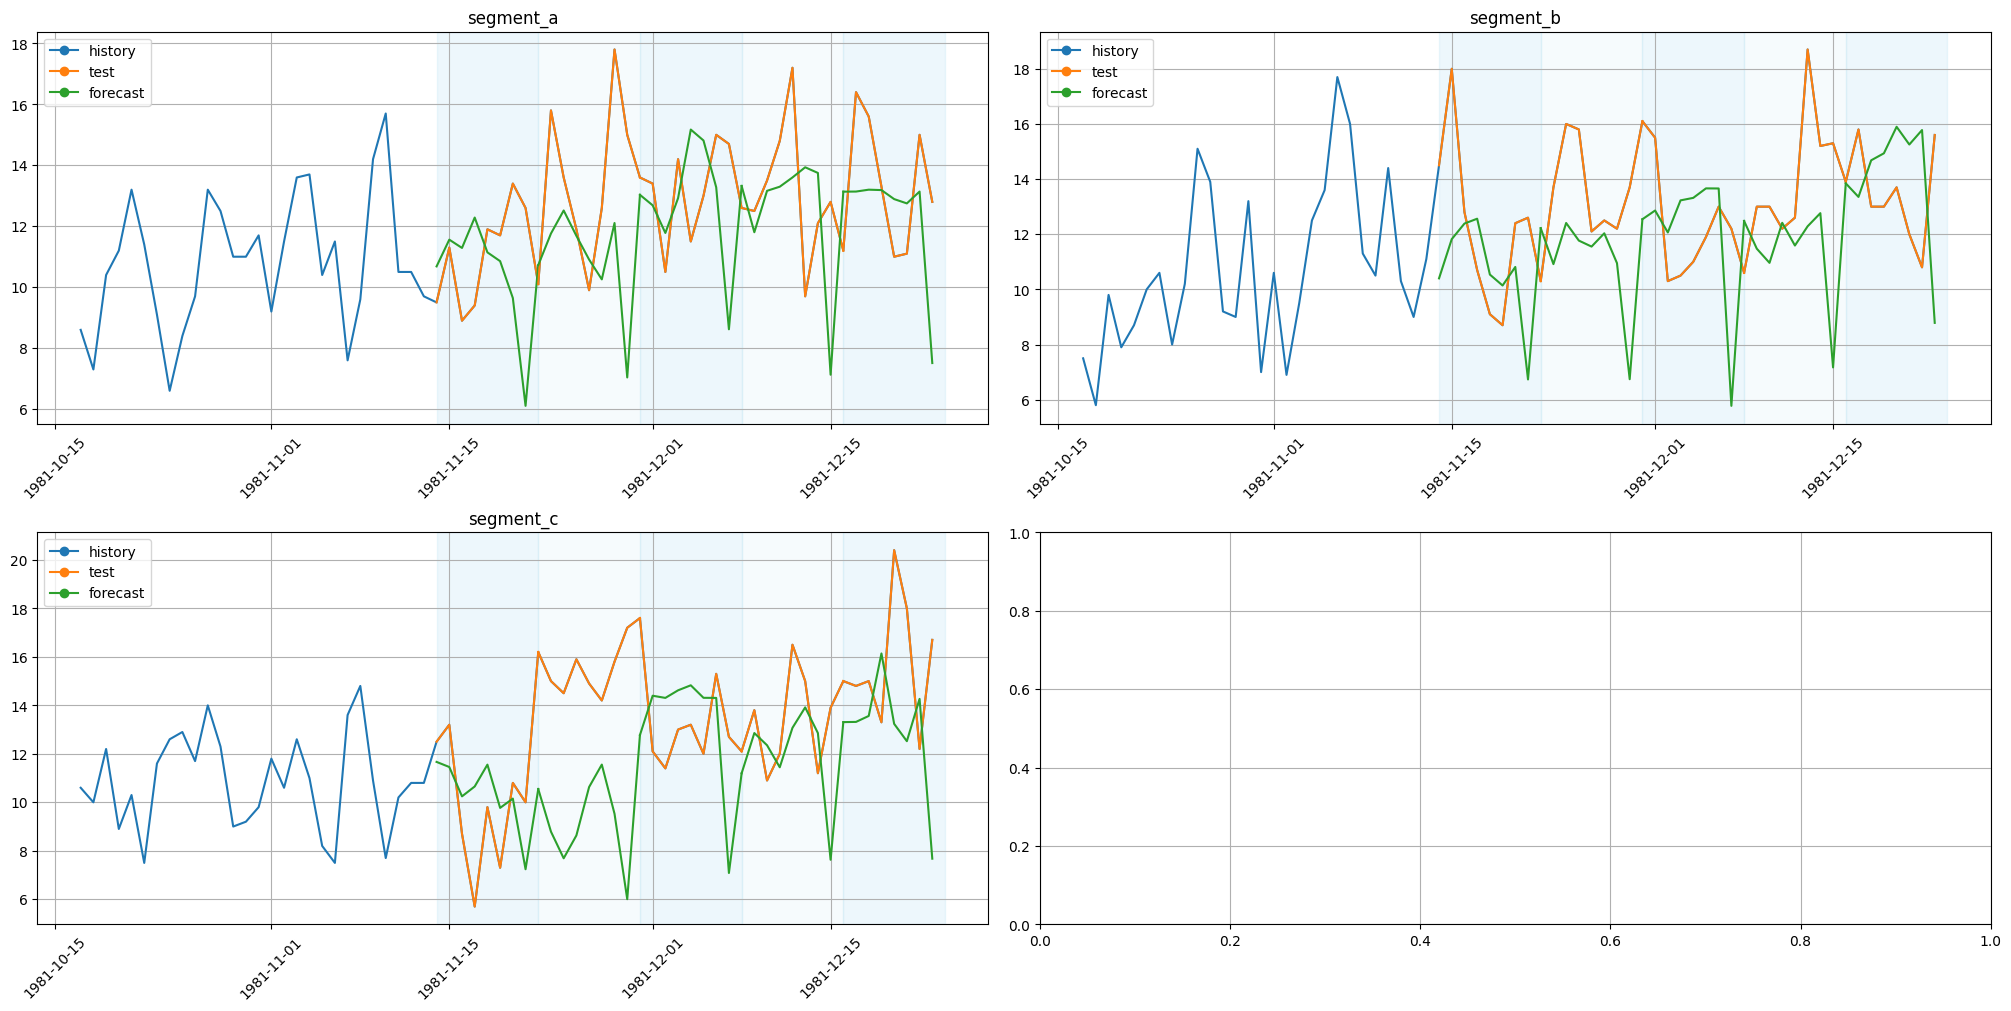

In [ ]:
plot_backtest(forecast_df, ts=train_ts, history_len=28)

In [ ]:
metrics_df

,segment,SMAPE,fold_number
0,segment_a,22.544340,0
0,segment_a,23.242451,1
0,segment_a,16.947425,2
0,segment_a,19.179195,3
0,segment_a,18.811090,4
1,segment_b,24.744024,0
1,segment_b,22.685278,1
1,segment_b,23.936916,2
1,segment_b,23.376716,3
1,segment_b,21.905683,4


In [ ]:
print(metrics_df.groupby('segment')['SMAPE'].mean())
print(metrics_df.groupby('segment')['SMAPE'].std())

segment
segment_a    20.144900
segment_b    23.329723
segment_c    28.188099
Name: SMAPE, dtype: float64
segment
segment_a     2.659305
segment_b     1.097080
segment_c    13.776286
Name: SMAPE, dtype: float64


## Подбор пространства используя lags2

In [ ]:
transforms2 = [lags2, mean8]
pipeline2 = Pipeline(model=model,
                    transforms=transforms2,
                    horizon=HORIZON)

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start='1981-01-01',
    train_end = '1981-12-23',
    test_start = '1981-12-24',
    test_end = '1981-12-31'
)

In [ ]:
metrics_df2, forecast_df2, fold_info_df2 = pipeline2.backtest(
    mode='expand',
    ts=train_ts,
    metrics=[smape]
)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   11.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   15.9s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   21.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   27.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:   27.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

In [ ]:
fold_info_df2

,train_start_time,train_end_time,test_start_time,test_end_time,fold_number
0,1981-01-01,1981-11-13,1981-11-14,1981-11-21,0
1,1981-01-01,1981-11-21,1981-11-22,1981-11-29,1
2,1981-01-01,1981-11-29,1981-11-30,1981-12-07,2
3,1981-01-01,1981-12-07,1981-12-08,1981-12-15,3
4,1981-01-01,1981-12-15,1981-12-16,1981-12-23,4


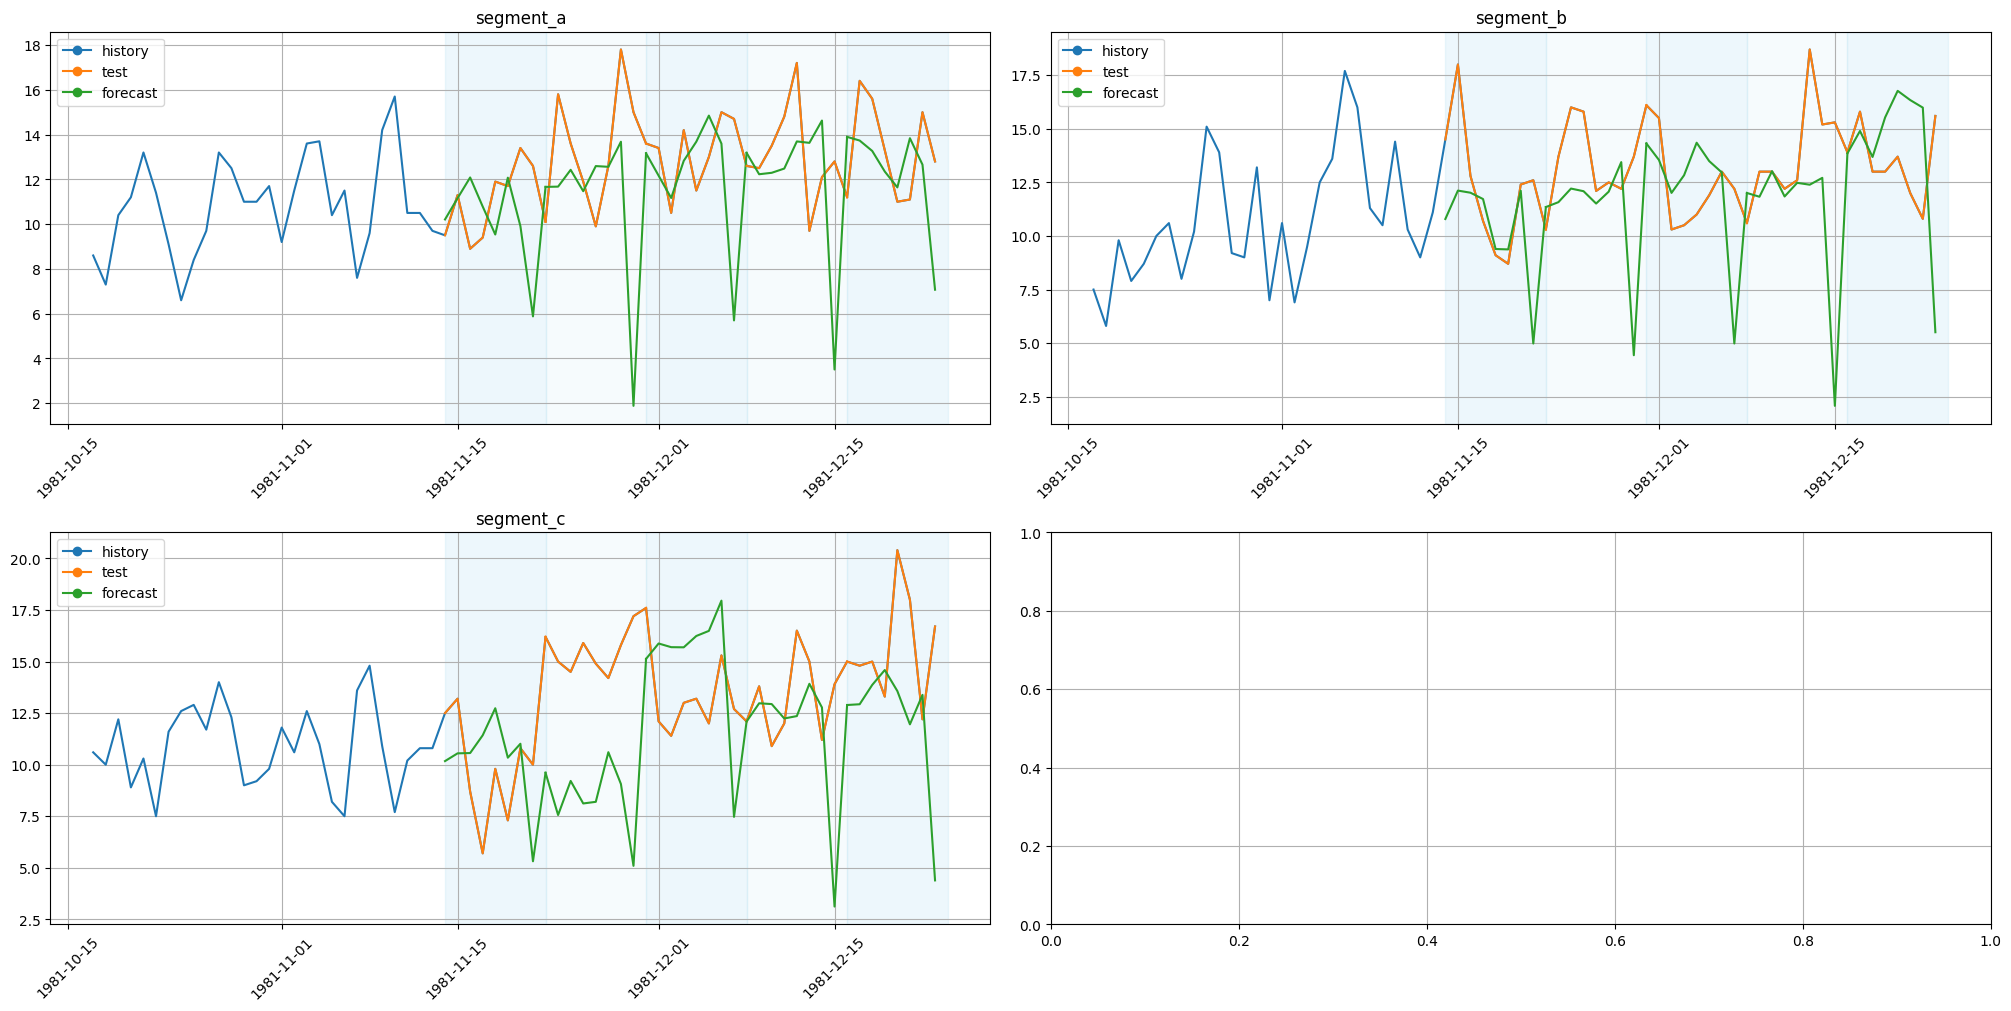

In [ ]:
plot_backtest(forecast_df2, ts=train_ts, history_len=28)

In [ ]:
metrics_df2

,segment,SMAPE,fold_number
0,segment_a,22.545610,0
0,segment_a,32.858467,1
0,segment_a,19.736702,2
0,segment_a,27.793651,3
0,segment_a,20.621872,4
1,segment_b,22.929432,0
1,segment_b,25.046400,1
1,segment_b,22.970406,2
1,segment_b,29.583148,3
1,segment_b,26.777286,4


In [ ]:
print(metrics_df2.groupby('segment')['SMAPE'].mean())
print(metrics_df2.groupby('segment')['SMAPE'].std())

segment
segment_a    24.711260
segment_b    25.461335
segment_c    34.870434
Name: SMAPE, dtype: float64
segment
segment_a     5.523529
segment_b     2.806622
segment_c    14.078237
Name: SMAPE, dtype: float64


# **5 Построение модели ARIMA**

In [ ]:
original_df = pd.read_csv('daily-minimum-temperatures_5.csv', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
original_df.head()

,target
timestamp,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


<Axes: xlabel='timestamp'>

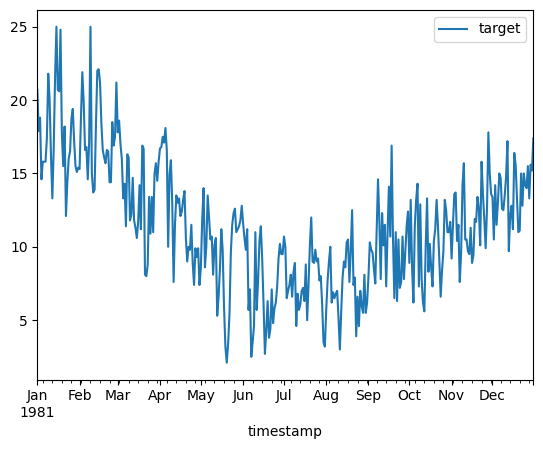

In [ ]:
original_df.plot()

In [ ]:
result = adfuller(original_df)
print(f'р-значение критерия Дикки-Фуллера: {adfuller(original_df)[1]}')

р-значение критерия Дикки-Фуллера: 0.12682316388801845


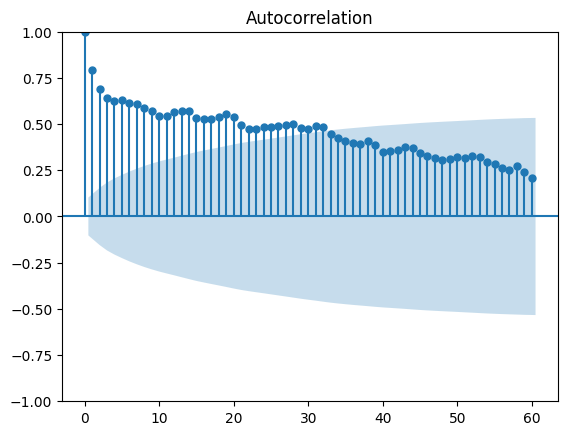

In [ ]:
plot_acf(original_df, lags=60);

In [ ]:
original_df['data_diff'] = original_df - original_df.shift(1)
print(f'Значение критерия Дикки-Фуллера: {adfuller(original_df.data_diff[1:])[1]}')

Значение критерия Дикки-Фуллера: 3.0570328858540606e-11


<Axes: xlabel='timestamp'>

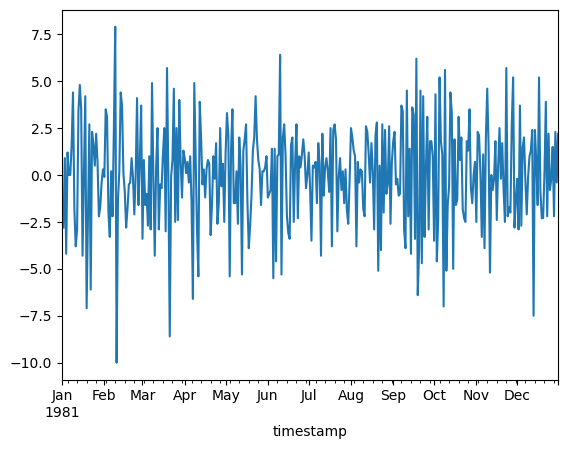

In [ ]:
original_df.data_diff.plot()

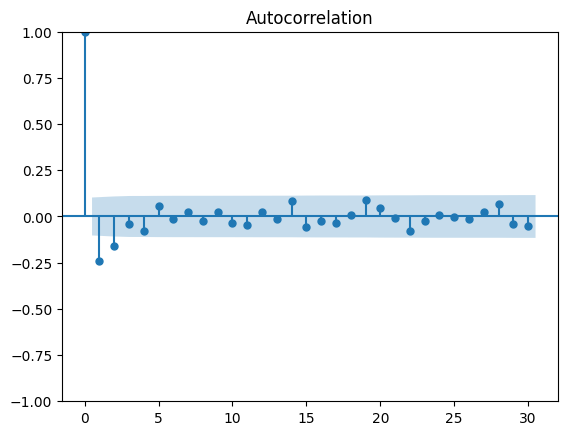

In [ ]:
plot_acf(original_df.data_diff[1:], lags=30);

Сезона нет

(-0.4, 0.4)

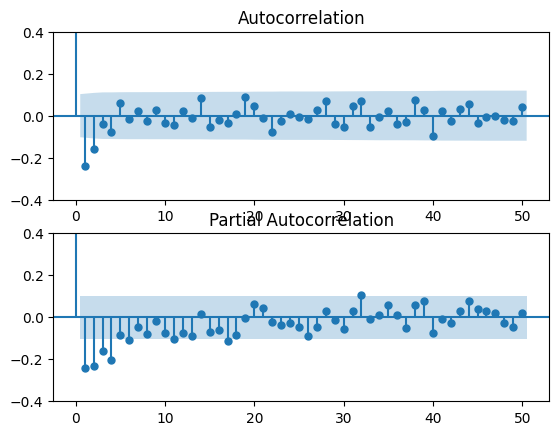

In [ ]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(original_df.data_diff[1:].values.squeeze(), lags=50, ax=ax)
plt.ylim([-0.4, 0.4])

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(original_df.data_diff[1:].values.squeeze(), lags=50, ax=ax)
plt.ylim([-0.4, 0.4])

$D=0$, $d=1$, $p=3$, $q=2$, $P=0$, $Q=0$

In [ ]:
D = 0
d = 1
Q = range(2)
q = range(3)
P = range(2)
p = range(5)

parametrs = list(product(p, q, P, Q))
print(len(parametrs))
print(parametrs)

60
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 1, 1), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 1, 0), (0, 1, 1, 1), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 1, 0), (0, 2, 1, 1), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1), (1, 1, 0, 0), (1, 1, 0, 1), (1, 1, 1, 0), (1, 1, 1, 1), (1, 2, 0, 0), (1, 2, 0, 1), (1, 2, 1, 0), (1, 2, 1, 1), (2, 0, 0, 0), (2, 0, 0, 1), (2, 0, 1, 0), (2, 0, 1, 1), (2, 1, 0, 0), (2, 1, 0, 1), (2, 1, 1, 0), (2, 1, 1, 1), (2, 2, 0, 0), (2, 2, 0, 1), (2, 2, 1, 0), (2, 2, 1, 1), (3, 0, 0, 0), (3, 0, 0, 1), (3, 0, 1, 0), (3, 0, 1, 1), (3, 1, 0, 0), (3, 1, 0, 1), (3, 1, 1, 0), (3, 1, 1, 1), (3, 2, 0, 0), (3, 2, 0, 1), (3, 2, 1, 0), (3, 2, 1, 1), (4, 0, 0, 0), (4, 0, 0, 1), (4, 0, 1, 0), (4, 0, 1, 1), (4, 1, 0, 0), (4, 1, 0, 1), (4, 1, 1, 0), (4, 1, 1, 1), (4, 2, 0, 0), (4, 2, 0, 1), (4, 2, 1, 0), (4, 2, 1, 1)]


In [ ]:
result = []
best_aic = float('inf')

for param in parametrs:
  model = sm.tsa.statespace.SARIMAX(original_df.target,
                                    order=(param[0], d, param[1]),
                                    seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
  aic = model.aic
  if aic < best_aic:
    best_model = model
    best_aic = aic
    best_param = param
  result.append([param, model.aic])

In [ ]:
df_table = pd.DataFrame(result)
df_table.columns = ['params', 'aic']
print(df_table.sort_values(by='aic', ascending=True))

          params          aic
16  (1, 1, 0, 0)  1682.721771
20  (1, 2, 0, 0)  1684.054780
28  (2, 1, 0, 0)  1684.073802
18  (1, 1, 1, 0)  1684.696266
17  (1, 1, 0, 1)  1684.696463
32  (2, 2, 0, 0)  1684.907153
22  (1, 2, 1, 0)  1686.040349
21  (1, 2, 0, 1)  1686.040380
30  (2, 1, 1, 0)  1686.061727
29  (2, 1, 0, 1)  1686.061764
40  (3, 1, 0, 0)  1686.062698
19  (1, 1, 1, 1)  1686.695810
34  (2, 2, 1, 0)  1686.860562
33  (2, 2, 0, 1)  1686.860772
44  (3, 2, 0, 0)  1686.907151
8   (0, 2, 0, 0)  1687.600932
52  (4, 1, 0, 0)  1687.919220
23  (1, 2, 1, 1)  1688.040929
42  (3, 1, 1, 0)  1688.046452
41  (3, 1, 0, 1)  1688.046485
31  (2, 1, 1, 1)  1688.062385
56  (4, 2, 0, 0)  1688.356020
46  (3, 2, 1, 0)  1688.860339
35  (2, 2, 1, 1)  1688.860435
45  (3, 2, 0, 1)  1688.860554
9   (0, 2, 0, 1)  1689.573938
10  (0, 2, 1, 0)  1689.574967
54  (4, 1, 1, 0)  1689.911811
53  (4, 1, 0, 1)  1689.911852
43  (3, 1, 1, 1)  1690.047429
58  (4, 2, 1, 0)  1690.349124
57  (4, 2, 0, 1)  1690.349201
11  (0, 2,

In [ ]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -838.361
Date:                Sun, 05 May 2024   AIC                           1682.722
Time:                        17:38:59   BIC                           1694.413
Sample:                    01-01-1981   HQIC                          1687.369
                         - 12-31-1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4523      0.057      7.923      0.000       0.340       0.564
ma.L1         -0.9156      0.026    -35.452      0.000      -0.966      -0.865
sigma2         5.8462      0.430     13.609      0.0

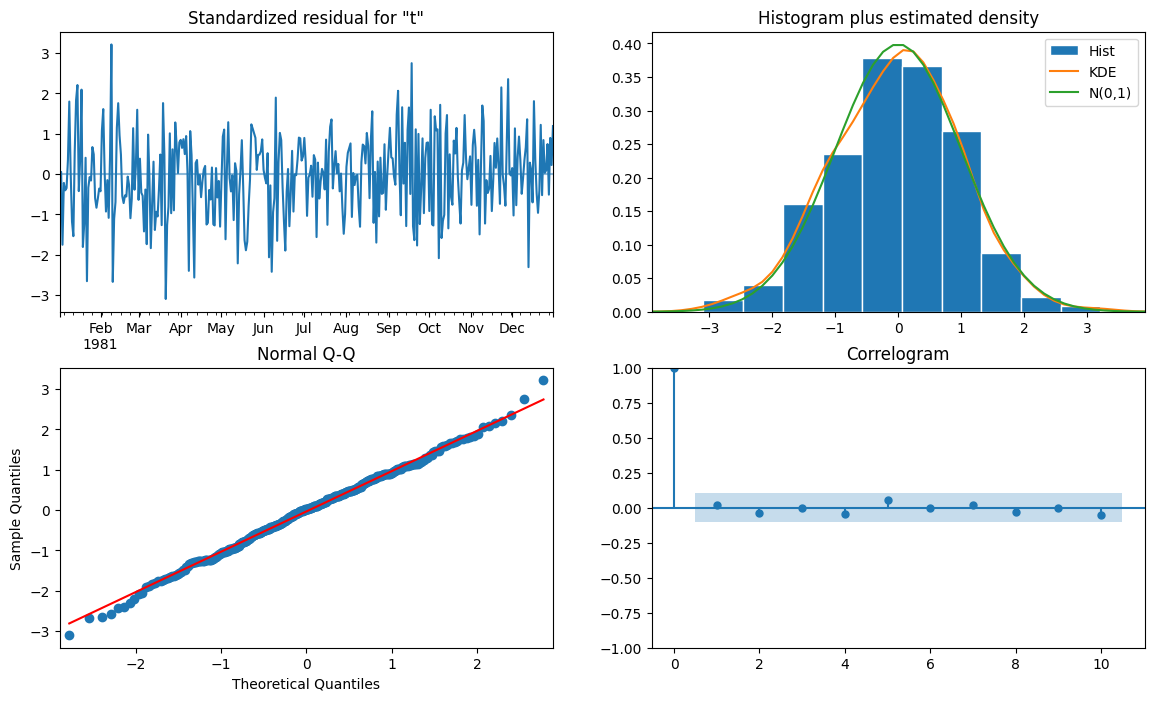

In [ ]:
best_model.plot_diagnostics(figsize=(14, 8))
plt.show()

In [ ]:
original_df = pd.read_csv('daily-minimum-temperatures_5.csv')
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  365 non-null    object 
 1   target     365 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


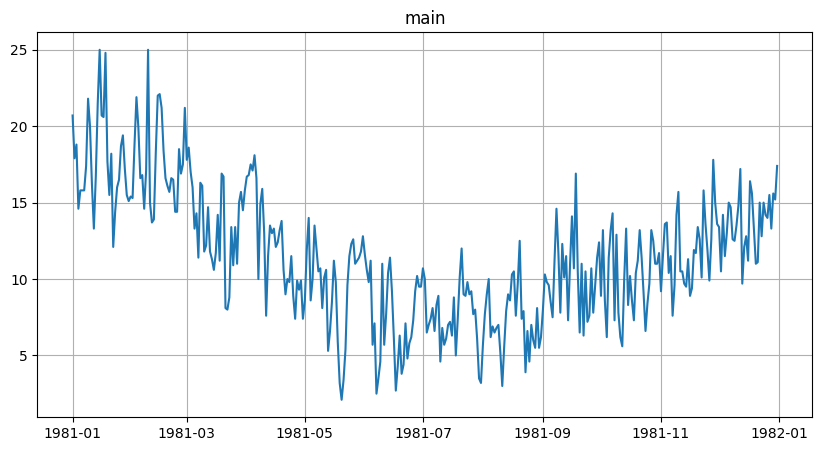

In [ ]:
original_df = pd.read_csv('daily-minimum-temperatures_5.csv')
original_df['segment'] = 'main'
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq='D')
ts.plot()

In [ ]:
HORIZON = 8

train_ts, test_ts = ts.train_test_split(train_start='1981-01-01',
                                        train_end = '1981-12-23',
                                        test_start = '1981-12-24',
                                        test_end = '1981-12-31')

In [ ]:
model = SARIMAXModel(order=(0, 1, 2),
                     seasonal_order=(4, 1, 0, 12))
model.fit(train_ts)

SARIMAXModel(order = (0, 1, 2), seasonal_order = (4, 1, 0, 12), trend = None, measurement_error = False, time_varying_regression = False, mle_regression = True, simple_differencing = False, enforce_stationarity = True, enforce_invertibility = True, hamilton_representation = False, concentrate_scale = False, trend_offset = 1, use_exact_diffuse = False, dates = None, freq = None, missing = 'none', validate_specification = True, fit_params = {}, )

In [ ]:
future_ts = train_ts.make_future(HORIZON)
future_ts

segment,main
feature,target
timestamp,
1981-12-24,NaN
1981-12-25,NaN
1981-12-26,NaN
1981-12-27,NaN
1981-12-28,NaN
1981-12-29,NaN
1981-12-30,NaN
1981-12-31,NaN


In [ ]:
forecast_ts = model.forecast(future_ts)
forecast_ts

segment,main
feature,target
timestamp,
1981-12-24,13.906543
1981-12-25,12.074209
1981-12-26,13.501035
1981-12-27,15.112159
1981-12-28,13.890654
1981-12-29,14.987885
1981-12-30,14.965976
1981-12-31,13.449498


In [ ]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 8.177442272746955}

In [ ]:
df.loc[len(df)] = ['SARIMAXModel', 8.177442272746955, 'segment_a']

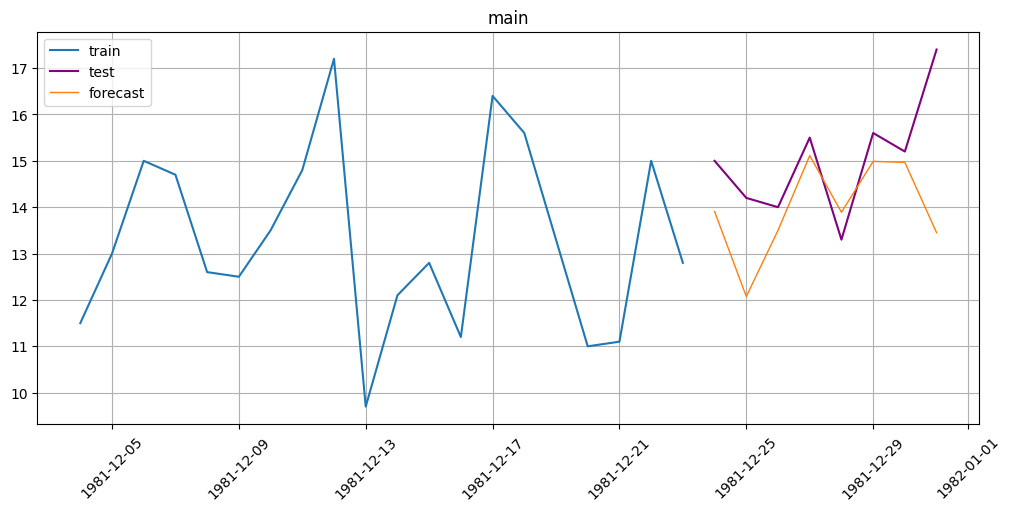

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

# **6 Построение ETS моделей**

В этом разделе построим модель экспоненциального среднего, модель Хольта, модель Хольта-Винтерса.

In [ ]:
original_df = pd.read_csv('daily-minimum-temperatures_5.csv')
original_df.head()

,timestamp,target
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
original_df['timestamp'] = pd.to_datetime(original_df['timestamp'])
original_df['segment'] = 'main'
original_df.head()

,timestamp,target,segment
0,1981-01-01,20.7,main
1,1981-01-02,17.9,main
2,1981-01-03,18.8,main
3,1981-01-04,14.6,main
4,1981-01-05,15.8,main


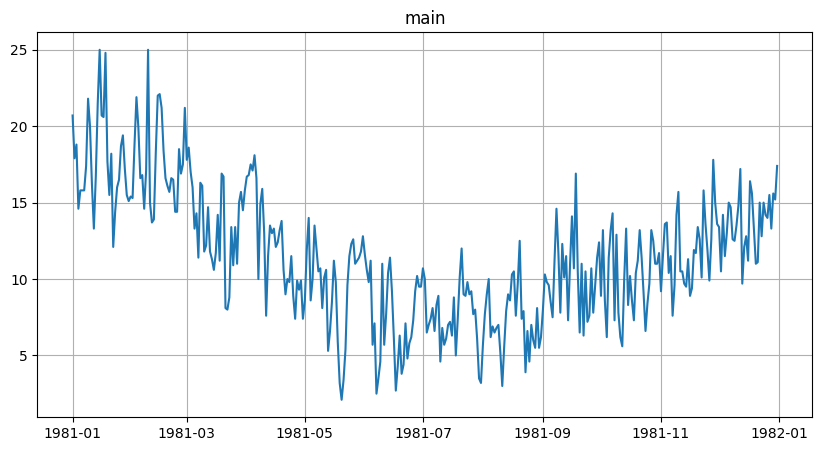

In [ ]:
df = TSDataset.to_dataset(original_df)
ts = TSDataset(df, freq='D')
ts.plot()

In [ ]:
HORIZON = 8
train_ts, test_ts = ts.train_test_split(
    train_start='1981-01-01',
    train_end = '1981-12-23',
    test_start = '1981-12-24',
    test_end = '1981-12-31'
)

In [ ]:
model = HoltWintersModel(
    seasonal='additive',
    trend='additive',
    seasonal_periods=12,
    smoothing_level=0.01,
    smoothing_trend=0.35,
    smoothing_seasonal=0.25
)

In [ ]:
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
forecast_ts

segment,main
feature,target
timestamp,
1981-12-24,15.486312
1981-12-25,13.536326
1981-12-26,13.934459
1981-12-27,14.915059
1981-12-28,14.021809
1981-12-29,15.765953
1981-12-30,16.030255
1981-12-31,14.614350


In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 5.169126836218789}

In [ ]:
df.loc[len(df)] = ['HoltWintersModel', 5.169126836218789, 'segment_a']

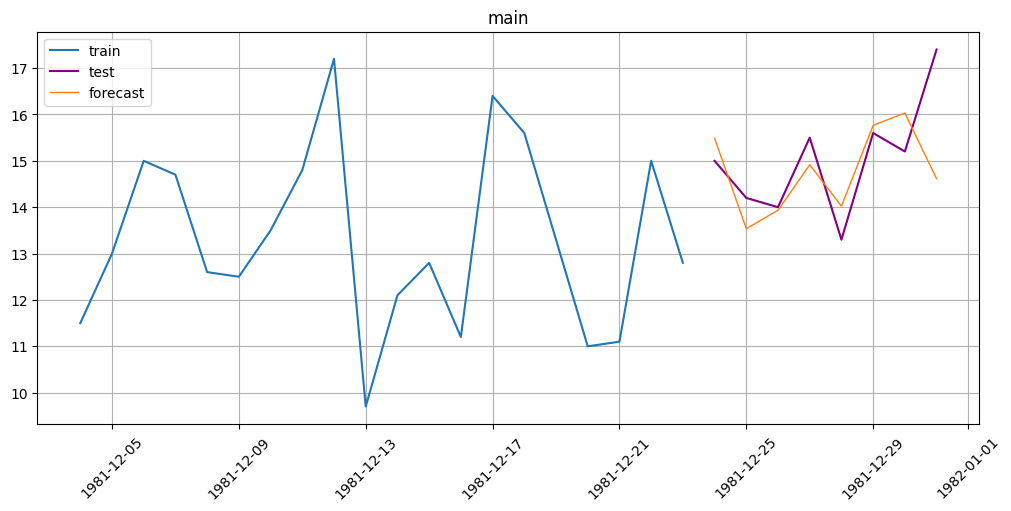

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

In [ ]:
model = SimpleExpSmoothingModel(
    seasonal_periods=18,
    smoothing_level=0.6,
    seasonal="add",
    use_boxcox=True,
    initialization_method="heuristic",
)

model.fit(train_ts)

future_ts = train_ts.make_future(HORIZON)

forecast_ts = model.forecast(future_ts)
forecast_ts

smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 8.444362460766062}

In [ ]:
df.loc[len(df)] = ['SimpleExpSmoothingModel', 8.444362460766062, 'segment_a']

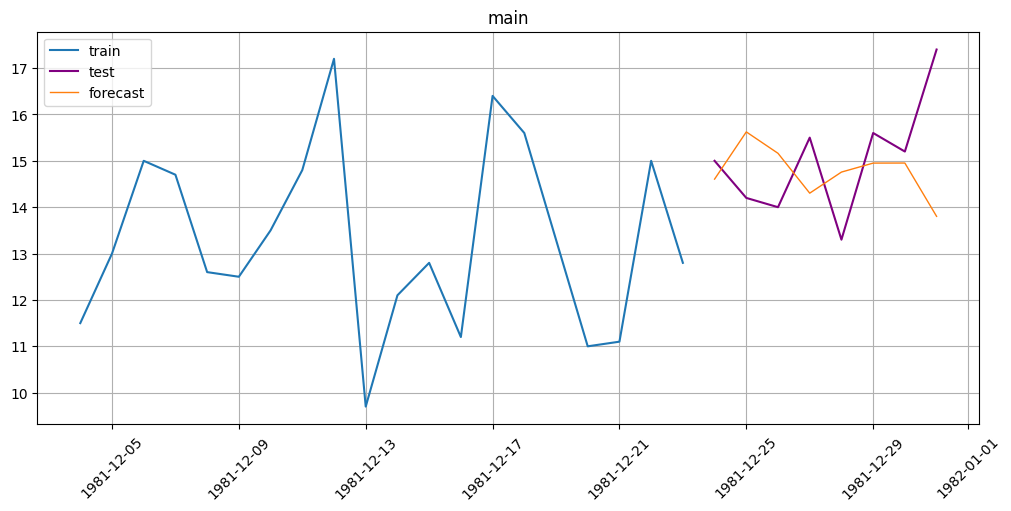

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

In [ ]:
model = HoltModel(
    seasonal='additive',
    seasonal_periods=12,
    smoothing_level=0.01,
    smoothing_trend=0.35,
    smoothing_seasonal=0.25
)

In [ ]:
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
forecast_ts

segment,main
feature,target
timestamp,
1981-12-24,15.486312
1981-12-25,13.536326
1981-12-26,13.934459
1981-12-27,14.915059
1981-12-28,14.021809
1981-12-29,15.765953
1981-12-30,16.030255
1981-12-31,14.614350


In [ ]:
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 5.169126836218789}

In [ ]:
df.loc[len(df)] = ['HoltModel', 5.169126836218789, 'segment_a']

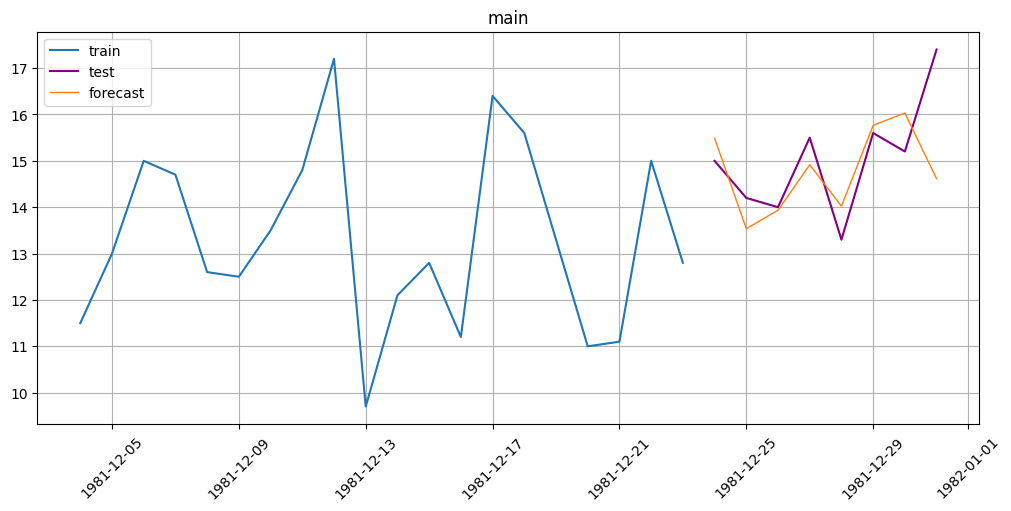

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=20)

# **7 Выводы**

Задача раздела: собрать воедино информацию о построенных моделях и сделать сравнительный анализ.

Для этого надо:
1.   собрать все графики моделей таким образом, чтобы можно было провести их визуальный анализ, у графиков должны быть подписаны оси и присутствовать легенда;
2.   собрать значение метрики $SMAPE$ всех моделей в таблицу (в датафрейм) и провести анализ.


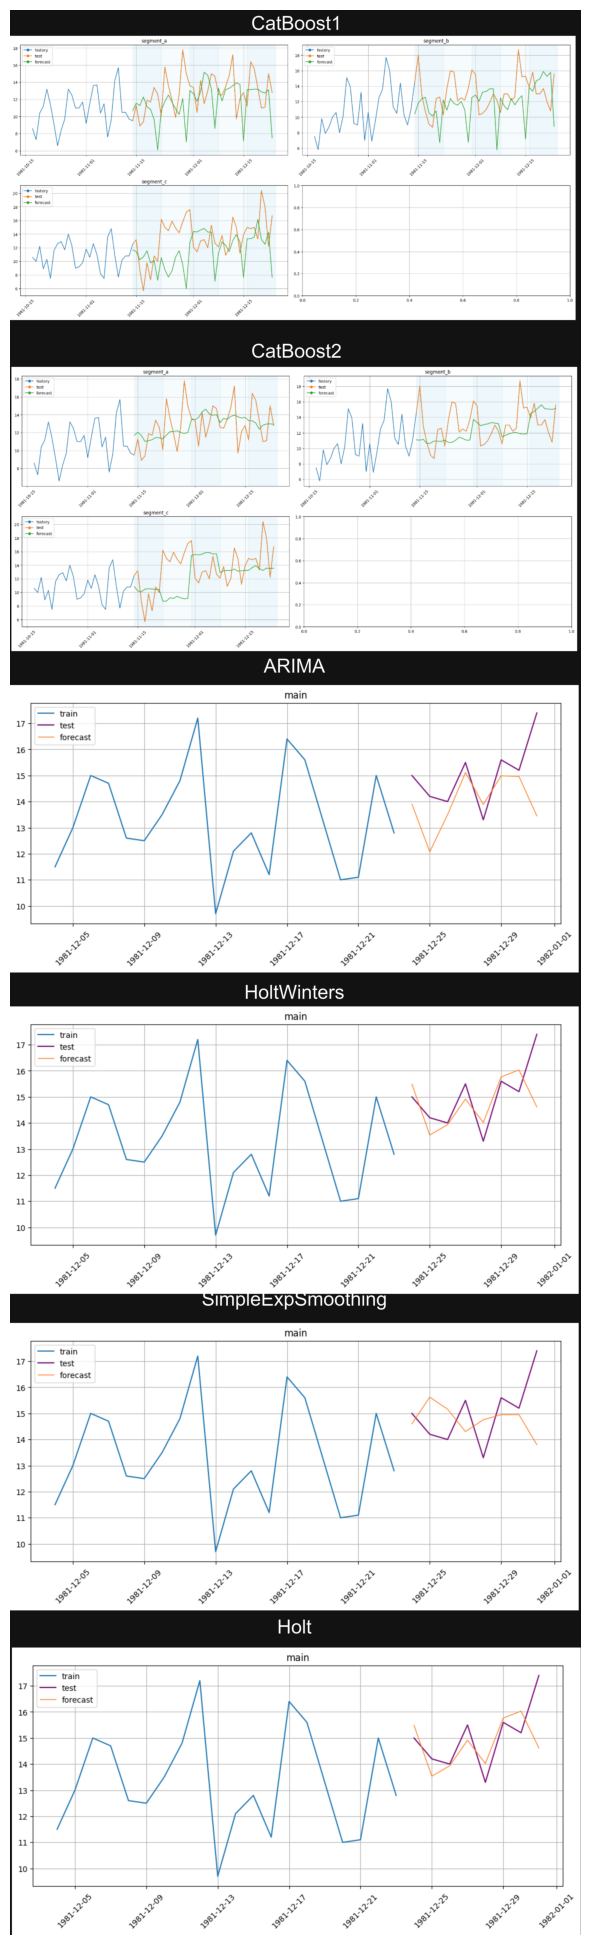

In [ ]:
import matplotlib.image as mpimg

img = mpimg.imread('Diagram.png')

fig = plt.figure(figsize=(50, 25))

ax = fig.add_subplot(111)

ax.imshow(img)
ax.axis('off')

plt.show()

In [ ]:
df

,Model Name,SMAPE,Segment
0,NaiveModel,6.818530,segment_a
1,NaiveModel,8.037511,segment_b
2,NaiveModel,19.254354,segment_c
3,MovingAverageModel,12.328455,segment_a
4,MovingAverageModel,12.926732,segment_b
5,MovingAverageModel,15.140348,segment_c
6,CatBoostMultiSegmentModel,18.811090,segment_a
7,CatBoostMultiSegmentModel,21.905683,segment_b
8,CatBoostMultiSegmentModel,27.505044,segment_c
9,CatBoostMultiSegmentModel с обновленным призна...,20.621872,segment_a


По показаниям метрики SMAPE, для сегмента, кторый отвечает за среднюю температуру воздуха, лучше всего себя показали модели Хольта, Хольта-Винтерса и SARIMAX. По графикам можно заметить, что модели смогли поймать сезонность ряда. Хуже всего на данном сегменте справилась модель CatBoost. Средний результат показали модель MovingAverageModel. Они попали в сезонность, однако не уловили тренд.